# Part 1
## Setup

We will be working with the following modules.

In [1]:
import pyro
import torch
import pyro.distributions as dist
import matplotlib.pyplot as plt
import numpy as np
print(plt.style.available)
plt.style.use('seaborn-ticks')

['seaborn-dark', 'seaborn-darkgrid', 'seaborn-ticks', 'fivethirtyeight', 'seaborn-whitegrid', 'classic', '_classic_test', 'fast', 'seaborn-talk', 'seaborn-dark-palette', 'seaborn-bright', 'seaborn-pastel', 'grayscale', 'seaborn-notebook', 'ggplot', 'seaborn-colorblind', 'seaborn-muted', 'seaborn', 'Solarize_Light2', 'seaborn-paper', 'bmh', 'tableau-colorblind10', 'seaborn-white', 'dark_background', 'seaborn-poster', 'seaborn-deep']


## Pyro's Distributions

There are [several distributions](http://docs.pyro.ai/en/stable/distributions.html) built into Pyro. Samples from a distribution are PyTorch Tensor objects, i.e. multidimensional arrays.

In [2]:
normal = dist.Normal(0, 1)
normal

Normal(loc: 0.0, scale: 1.0)

In [3]:
sample = normal.sample()
sample

tensor(-1.4515)

In [4]:
sample = normal.sample(sample_shape=[3, 4, 2])
sample

tensor([[[ 0.8728, -1.5283],
         [-0.9184, -1.0423],
         [ 1.5613, -0.5816],
         [-0.0688, -0.1414]],

        [[ 2.0388, -1.1210],
         [ 0.1119,  1.3273],
         [-0.3461, -0.3078],
         [ 0.0223,  0.8931]],

        [[-1.3703,  0.3330],
         [ 0.0761, -0.0574],
         [-0.1792, -0.0580],
         [-1.4850,  0.6446]]])

If we want to know the dimensionality of a sample, we can simply get the `.shape` property from the `tensor` object.

In [5]:
sample.shape

torch.Size([3, 4, 2])

It is also possible to do operations such as the log-likelihood (the natural logarithm of the probability density function at the given value) over tensors.

In [6]:
normal.log_prob(sample)

tensor([[[-1.2998, -2.0868],
         [-1.3407, -1.4621],
         [-2.1377, -1.0881],
         [-0.9213, -0.9289]],

        [[-2.9972, -1.5473],
         [-0.9252, -1.7998],
         [-0.9788, -0.9663],
         [-0.9192, -1.3178]],

        [[-1.8579, -0.9744],
         [-0.9218, -0.9206],
         [-0.9350, -0.9206],
         [-2.0215, -1.1267]]])

In [7]:
torch.sum(normal.log_prob(sample))

tensor(-32.3955)

A single object may hold several distributions. In the following example, three normal distributions with three separate means and the same standard deviation are assigned to `normal`.

In [8]:
normal = dist.Normal(torch.tensor([1.0, 2.0, 3.0]), 1.0) # μ = 1, 2, 3; σ = 1 ∀ variables
normal

Normal(loc: torch.Size([3]), scale: torch.Size([3]))

In [9]:
normal.sample()

tensor([-1.1147,  2.0216,  1.5405])

## Modelling in Pyro
In Pyro, a probabilistic model is defined as a stochastic function; every time it runs, it returns a new sample. Each random variable is associated with a primitive stochastic function through the `pyro.sample()` method.

### A Temperature Model
Following along [the Probabilistic AI Tutorial](https://github.com/PGM-Lab/probabilisticAI_tutorials/blob/master/Day1/students_PPLs_Intro.ipynb), we begin by constructing a simple temperature model. Let's begin by assuming the temperature at any given moment is a normally distributed stochastic variable $T$ with mean 15 and standard deviation 2, i.e. $T \sim \mathcal{N}(15, 4)$.

In [10]:
def temperature_model():
    return pyro.sample('temp', dist.Normal(15.0, 2.0))

for i in range(5):
    print(temperature_model())

tensor(14.2389)
tensor(13.4378)
tensor(13.8031)
tensor(15.3261)
tensor(16.4883)


We could also add a sensor to our model, assuming this is what gives us our readings. We will assume the sensor is unbiased (i.e. the mean of the sensor is the true value), and the error in the sensor is known.

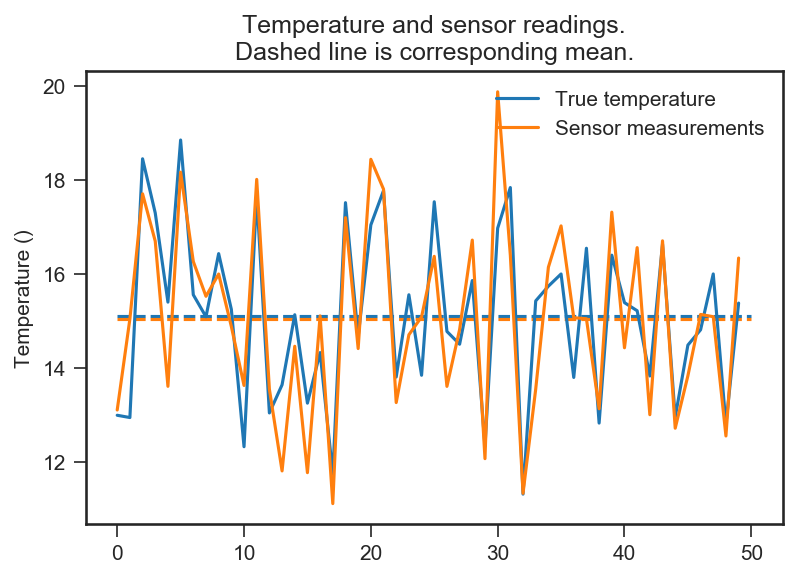

In [11]:
def extended_temperature_model():
    temp = pyro.sample('temp', dist.Normal(15.0, 2.0))
    sensor_reading = pyro.sample('sensor_reading', dist.Normal(temp, 1.0))
    return temp, sensor_reading


temp, sensor_reading = ([], [])
for i in range(50):
    current_temp, current_sensor_reading = extended_temperature_model()
    temp.append(current_temp.item())
    sensor_reading.append(current_sensor_reading.item())

plt.figure(dpi=150)
plt.plot(temp, label='True temperature')
plt.plot(sensor_reading, label='Sensor measurements')
plt.hlines(np.mean(temp), 0, 50, linestyle='--', color='C0')
plt.hlines(np.mean(sensor_reading), 0, 50, linestyle='--', color='C1')
plt.title('Temperature and sensor readings.\nDashed line is corresponding mean.')
plt.ylabel(r'Temperature ()')
plt.legend();

The above model defines the joint distribution
$$
  P(\text{sensor},\, \text{temperature)} = P(\text{sensor}\mid\text{temperature)} P(\text{temperature)}
$$

## Inference

Generating random data is fine, but what we are really interested in is doing inference based on observed data. Pyro uses a variational inference method, performing gradient-based optimization to solve the inference problem. I still need to learn exactly what that means.

In [12]:
from torch.distributions import constraints
from pyro.optim import SGD
from pyro.infer import Trace_ELBO
from pyro.contrib.autoguide import AutoDiagonalNormal

def svi(temperature_model, guide, obs, num_steps=5000, plot=False):
    pyro.clear_param_store()
    svi = pyro.infer.SVI(
        model=temperature_model,                     
        guide=guide,           
        optim=SGD({ 'lr': 0.001, "momentum": 0.1 }),           
        loss=Trace_ELBO()
    )
    losses, a, b = [], [], []
    
    for t in range(num_steps):
        losses.append(svi.step(obs))
    
    if plot:
        plt.figure(dpi=150)
        plt.plot(losses)
        plt.title("ELBO")
        plt.xlabel("step")
        plt.ylabel("loss")
        plt.show();

### Conditioning on a single observation

Let's assume we have a single sensor reading, and based upon this we would like to compute the posterior distribution over the real temperature. In other words, we have taken a temperature measurement. Given this measurement, what is the distribution of the _true_ temperature?

In [13]:
# The observation
obs = {"sensor_reading" : torch.tensor(18.0)}

def model(obs):
    temp = pyro.sample("temp", dist.Normal(15.0, 2.0))
    sensor_reading = pyro.sample("sensor_reading", dist.Normal(temp, 1.0), obs=obs["sensor_reading"])

To make inference in Pyro over a given model we need to define a _guide_. This guide must have the same signature as its counterpart model, and the guide must provide samples for the variables of the model that are not observed by again using the `pyro.sample` method. Guides are parameterized using Pyro's parameters `pyro.param`, so the variational inference algortithm will optimize these parameters. This will be explained later.

In [14]:
# The guide
def guide(obs):
    a = pyro.param("mean", torch.tensor(0.0))
    b = pyro.param("scale", torch.tensor(1.0), constraint=constraints.positive)
    temp = pyro.sample("temp", dist.Normal(a, b))

We are now ready to run inference and query the posterior $P(\text{temperature} \mid \text{sensor} = 18)$.

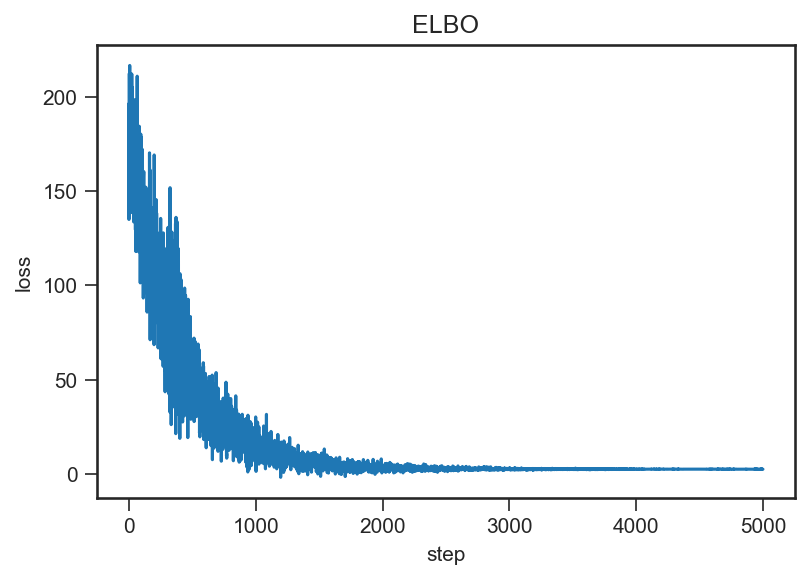

P( Temperature | Sensor = 18.0 ) = Normal(loc: 17.42918586730957, scale: 0.9239730834960938)


In [15]:
# Run inference
svi(model, guide, obs, plot=True)

# Print the results
print(f"P( Temperature | Sensor = 18.0 ) = {dist.Normal(pyro.param('mean').item(), pyro.param('scale').item())}")

The print shows the result of the inference, and in the plot we can see how the loss function develops as a function of iterations.

### Learning from many observations

Of course, many observations are better than just one. We assume we have many different sensor readings, and define a random variable for each of the corresponding observations

In [16]:
# The observations
obs = {"sensor_readings": torch.tensor([18.,
                                        18.7,
                                        19.2,
                                        17.8,
                                        20.3,
                                        22.4,
                                        20.3,
                                        21.2,
                                        19.5,
                                        20.1])}

In [17]:
def model(obs):
    for i in range(obs["sensor_readings"].shape[0]):
        temp = pyro.sample(f"temp_{i}", dist.Normal(15.0, 2.0))
        
        sensor_reading = pyro.sample(f"sensor_reading_{i}",
                                     dist.Normal(temp, 1.0),
                                     obs=obs["sensor_readings"][i])

Now, the mean we have selected for the temperture is just a guess, and we would like to infer a better one from our sensor readings. Analytically, this would be done through solving a maximum likelihood function, but we aren't interested in doing it by hand. Instead, we want Pyro to do it for us. We again need a guide with free paramaters for Pyro to optimize.

In [18]:
# The model
def model(obs):
    mean_temp = pyro.param("mean_temp", torch.tensor(15.0))
    for i in range(obs["sensor_readings"].shape[0]):
        temp = pyro.sample(f"temp_{i}", dist.Normal(mean_temp, 2.0))
        sensor = pyro.sample(f"sensor_{i}", dist.Normal(temp, 1.0), obs=obs["sensor_readings"][i])

In [19]:
# The guide
def guide(obs):
    for i in range(obs["sensor_readings"].shape[0]):
        mean_i = pyro.param(f"mean_{i}", obs["sensor_readings"][i])
        scale_i = pyro.param(f"scale_{i}", torch.tensor(1.0), constraint=constraints.positive)
        temp = pyro.sample(f"temp_{i}", dist.Normal(mean_i, scale_i))

In [20]:
# Run inference
svi(model, guide, obs, num_steps=1000)

In [21]:
# Print results
print("Estimated Mean Temperature")
print(pyro.param("mean_temp").item())

Estimated Mean Temperature
19.105152130126953


Now, instead of doing a point estimate of the mean temperature as a parameter, we can perform _Bayesian learning_ and treat the unknown as a random variable.

In [22]:
def model(obs):
    mean_temp = pyro.sample("mean_temp", dist.Normal(15.0, 2.0))
    for i in range(obs["sensor_readings"].shape[0]):
        temp = pyro.sample(f"temp_{i}", dist.Normal(mean_temp, 2.0))
        sensor = pyro.sample(f"sensor_{i}", dist.Normal(temp, 1.0), obs=obs["sensor_readings"][i])

In [23]:
def guide(obs):
    mean = pyro.param("mean", torch.mean(obs["sensor_readings"]))
    scale = pyro.param("scale", torch.tensor(1.0), constraint=constraints.positive)
    mean_temp = pyro.sample("mean_temp", dist.Normal(mean, scale))
    for i in range(obs["sensor_readings"].shape[0]):
        mean_i = pyro.param(f"mean_{i}", obs["sensor_readings"][i])
        scale_i = pyro.param(f"scale_{i}", torch.tensor(1.0), constraint=constraints.positive)
        temp = pyro.sample(f"temp_{i}", dist.Normal(mean_i, scale_i))

In [24]:
import time
        
#Run inference
start = time.time()
svi(model, guide, obs, num_steps=1000)

#Print results
print("P(mean_temp|Sensor=[18., 18.7, 19.2, 17.8, 20.3, 22.4, 20.3, 21.2, 19.5, 20.1]) =")
print(dist.Normal(pyro.param("mean").item(), pyro.param("scale").item()))
print("")
end = time.time()
print(f"{(end - start)} seconds")

P(mean_temp|Sensor=[18., 18.7, 19.2, 17.8, 20.3, 22.4, 20.3, 21.2, 19.5, 20.1]) =
Normal(loc: 18.929899215698242, scale: 0.6216435432434082)

14.725212097167969 seconds


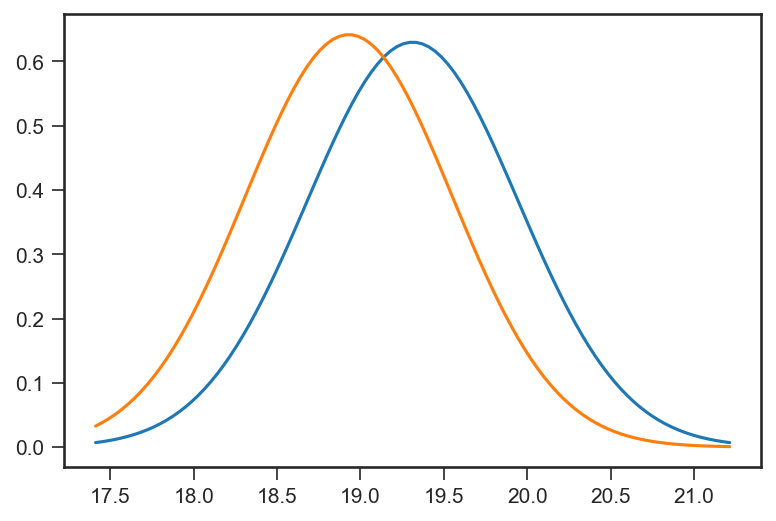

In [25]:
import scipy.stats as stats
true_mu = 19.312837600708008
true_scale = 0.6332376003265381

estimated_mu = pyro.param("mean").item()
estimated_scale = pyro.param("scale").item()

x = np.linspace(true_mu - 3 * true_scale, true_mu + 3 * true_scale, 100)
plt.figure(dpi=150)
plt.plot(x, stats.norm.pdf(x, true_mu, true_scale))
plt.plot(x, stats.norm.pdf(x, estimated_mu, estimated_scale));

### Plate notation

Pyro has incorporated a [construct called `plate`](http://docs.pyro.ai/en/dev/primitives.html#pyro.plate), referring to the terminollogy used in modelling random dependencies with [graphs](https://en.wikipedia.org/wiki/Plate_notation). Consider the following code:

In [125]:
def model(obs):
    mean_temp = pyro.sample("mean_temp", dist.Normal(15.0, 2.0))
    with pyro.plate("a", obs["sensor_readings"].shape[0]):
        temp = pyro.sample("temp", dist.Normal(15.0, 2.0))
        sensor_readings = pyro.sample("sensor_readings", dist.Normal(temp, 1.0), obs=obs["sensor_readings"])

This means that the variables $T_i$ and $S_i$ are conditionally independent of $T_j$ and $S_j$ given $\mu$. This also means there is a natural distinction between **local** and **global** random variables. The former captures information about the system specific to the _i_-th data sample (such as the real temperature), where the latter captuers information common to all data samples (such as the true temperature mean).

This model is much faster:

In [126]:
def guide(obs):
    mean = pyro.param("mean", torch.mean(obs["sensor_readings"]))
    scale = pyro.param("scale", torch.tensor(1.0), constraint=constraints.positive)
    mean_temp = pyro.sample("mean_temp", dist.Normal(mean, scale))
    with pyro.plate("a", obs["sensor_readings"].shape[0]) as i:
        mean_i = pyro.param("mean_i", obs["sensor_readings"][i])
        scale_i = pyro.param("scale_i", torch.tensor(1.0), constraint=constraints.positive)
        temp = pyro.sample("temp", dist.Normal(mean_i, scale_i))

In [128]:
# Run inference
import time
start = time.time()
svi(model, guide, obs, num_steps=1000)

#Print results
print("P(mean_temp|Sensor=[18., 18.7, 19.2, 17.8, 20.3, 22.4, 20.3, 21.2, 19.5, 20.1]) =")
print(dist.Normal(pyro.param("mean").item(), pyro.param("scale").item()))
print("")
end = time.time()
print(f"{(end - start)} seconds")

KeyError: 'sensor_readings'

In [47]:
#The observatons   
obs = {'sensor_readings': torch.tensor([18., 18.7, 19.2, 17.8, 20.3, 22.4, 20.3, 21.2, 19.5, 20.1, 18.1, 18.2, 18.2, 19.1, 18.1])}

def model(obs):
    mean_temp = pyro.sample('mean_temp', dist.Normal(15.0, 2.))
    with pyro.plate('a', obs['sensor_readings'].shape[0]):
        temp = pyro.sample('temp', dist.Normal(mean_temp, 2.0))
        sensor_readings = pyro.sample('sensor_readings', dist.Normal(temp, 1.0), obs=obs['sensor_readings'])

#Run inference
svi(model, guide, obs, num_steps=1000)

#Print results
print("P(Temperature|Sensor=18.0) = ")
print(dist.Normal(pyro.param("mean").item(), pyro.param("scale").item()))

P(Temperature|Sensor=18.0) = 
Normal(loc: 18.976390838623047, scale: 0.5066227316856384)


## Ice Cream Shop

We have a lovely ice cream shop, and we record sales per day as well as the average temperature that day. We suspect the two are linked, and we would like to model exactly how.

<img src="https://github.com/erikaja/probabilisticAI_tutorials/raw/40b644dccee2d26e469bb5fd32ae01e430e66200/Day1/slides/Figures/Ice-cream_shop_-_Florida.jpg" style="width: 80%; margin: 0 auto;">

We assume the sales follow a Poisson distribution, where the mean parameter linearly depends on the real temperature that day. The coefficients of this relationship are modelled as random variables.

In [48]:
#The observatons   
obs = {'sensor': torch.tensor([18., 18.7, 19.2, 17.8, 20.3, 22.4, 20.3, 21.2, 19.5, 20.1]),
       'sales': torch.tensor([46., 47., 49., 44., 50., 54., 51., 52., 49., 53.])}

def model(obs):
    mean_temp = pyro.sample('mean_temp', dist.Normal(15.0, 2.0))
    alpha = pyro.sample('alpha', dist.Normal(0.0, 100.0))
    beta = pyro.sample('beta', dist.Normal(0.0, 100.0))

    with pyro.plate('a', obs['sensor'].shape[0]):
        temp = pyro.sample('temp', dist.Normal(mean_temp, 2.0))
        sensor = pyro.sample('sensor', dist.Normal(temp, 1.0), obs=obs['sensor'])
        rate = torch.max(torch.tensor(0.001), alpha + beta*temp)
        sales = pyro.sample('sales', dist.Poisson(rate), obs=obs['sales'])
        
#Define the guide
def guide(obs):
    mean = pyro.param("mean", torch.mean(obs['sensor']))
    scale = pyro.param("scale", torch.tensor(1.), constraint=constraints.positive)
    mean_temp = pyro.sample('mean_temp', dist.Normal(mean, scale))

    alpha_mean = pyro.param("alpha_mean", torch.mean(obs['sensor']))
    alpha_scale = pyro.param("alpha_scale", torch.tensor(1.), constraint=constraints.positive)
    alpha = pyro.sample('alpha', dist.Normal(alpha_mean, alpha_scale))

    beta_mean = pyro.param("beta_mean", torch.tensor(1.0))
    beta_scale = pyro.param("beta_scale", torch.tensor(1.), constraint=constraints.positive)
    beta = pyro.sample('beta', dist.Normal(beta_mean, beta_scale))

    with pyro.plate('a', obs['sensor'].shape[0]) as i:
        mean_i = pyro.param('mean_i', obs['sensor'][i])
        scale_i = pyro.param('scale_i', torch.tensor(1.), constraint=constraints.positive)
        temp = pyro.sample('temp', dist.Normal(mean_i, scale_i))

That is, we expect the number of sales each day to be Poisson distributed with rate $\alpha + \beta \cdot T_i$.

In [49]:
#Run inference
svi(model, guide, obs, num_steps=1000)

#Print results    
print("Posterior Temperature Mean")
print(dist.Normal(pyro.param("mean").item(), pyro.param("scale").item()))
print("")
print("Posterior Alpha")
print(dist.Normal(pyro.param("alpha_mean").item(), pyro.param("alpha_scale").item()))
print("")
print("Posterior Beta")
print(dist.Normal(pyro.param("beta_mean").item(), pyro.param("beta_scale").item()))

Posterior Temperature Mean
Normal(loc: 19.294872283935547, scale: 0.5882347822189331)

Posterior Alpha
Normal(loc: 19.775373458862305, scale: 1.878173589706421)

Posterior Beta
Normal(loc: 1.5342378616333008, scale: 0.12032082676887512)


Doing the math means that we on an average day expect to sell around 49 ice cream. Of course this model (as most other models) has limited validity; using it blindly would make us expect selling 19 ice cream on a day where precipitation would fall as snow.

### What About Humidity?

We could also be interested in other parameters. Let's say we also record the humidity of the air, because we suspect this is also a part of the linear relationship between the weather and the expected ice cream sales:

In [53]:
#The observatons   
obs = {'sensor': torch.tensor([18., 18.7, 19.2, 17.8, 20.3, 22.4, 20.3, 21.2, 19.5, 20.1]),
       'sales': torch.tensor([46., 47., 49., 44., 50., 54., 51., 52., 49., 53.]),
       'sensor_humidity': torch.tensor([82.8, 87.6, 69.1, 74.2, 80.3, 94.2, 91.2, 92.2, 99.1, 93.2])}


def model(obs):
    mean_temp = pyro.sample('mean_temp', dist.Normal(15.0, 2.0))
    ## Introduce a random variable "humidity_mean"
    mean_humidity = pyro.sample("mean_humidity", dist.Normal(80.0, 5.0))
    alpha = pyro.sample('alpha', dist.Normal(0.0, 100.0))
    beta = pyro.sample('beta', dist.Normal(0.0, 100.0))
    gamma = pyro.sample('gamma', dist.Normal(0.0, 100.0))
    
    ## Introduce a coefficient for the humidity "gamma"

    with pyro.plate('a', obs['sensor'].shape[0]):
        temp = pyro.sample('temp', dist.Normal(mean_temp, 2.0))
        sensor = pyro.sample('sensor', dist.Normal(temp, 1.0), obs=obs['sensor'])
        #Add the 'humidity' variable and the 'sensor_humidity' variable
        humidity = pyro.sample('humidity', dist.Normal(mean_humidity, 5.0))
        sensor_humidity = pyro.sample('sensor_humidity', dist.Normal(humidity, 1.0), obs=obs['sensor_humidity'])
        rate = torch.max(torch.tensor(0.001), alpha + beta * temp + gamma * humidity)
        sales = pyro.sample('sales', dist.Poisson(rate), obs=obs['sales'])

In [51]:
def guide(obs):
    mean = pyro.param("mean", torch.mean(obs['sensor']))
    scale = pyro.param("scale", torch.tensor(1.), constraint=constraints.positive)
    mean_temp = pyro.sample('mean_temp', dist.Normal(mean, scale))

    meanH = pyro.param("meanH", torch.mean(obs['sensor_humidity']))
    scaleH = pyro.param("scaleH", torch.tensor(1.), constraint=constraints.positive)
    humidity_mean = pyro.sample('humidity_mean', dist.Normal(meanH, scaleH))


    alpha_mean = pyro.param("alpha_mean", torch.mean(obs['sensor']), constraint=constraints.positive)
    alpha_scale = pyro.param("alpha_scale", torch.tensor(1.), constraint=constraints.positive)
    alpha = pyro.sample('alpha', dist.Normal(alpha_mean, alpha_scale))

    beta_mean = pyro.param("beta_mean", torch.tensor(1.0), constraint=constraints.positive)
    beta_scale = pyro.param("beta_scale", torch.tensor(1.), constraint=constraints.positive)
    beta = pyro.sample('beta', dist.Normal(beta_mean, beta_scale))

    gamma_mean = pyro.param("gamma_mean", torch.tensor(1.0), constraint=constraints.positive)
    gamma_scale = pyro.param("gamma_scale", torch.tensor(1.), constraint=constraints.positive)
    gamma = pyro.sample('gamma', dist.Normal(gamma_mean, gamma_scale))

    with pyro.plate('a', obs['sensor'].shape[0]) as i:
        mean_i = pyro.param('mean_i', obs['sensor'][i])
        scale_i = pyro.param('scale_i', torch.tensor(1.), constraint=constraints.positive)
        temp = pyro.sample('temp', dist.Normal(mean_i, scale_i))
        meanH_i = pyro.param('meanH_i', obs['sensor_humidity'][i])
        scaleH_i = pyro.param('scaleH_i', torch.tensor(1.), constraint=constraints.positive)
        humidity = pyro.sample('humidity', dist.Normal(meanH_i, scaleH_i))

In [54]:
#Run inference
svi(model, guide, obs, num_steps=1000)

#Print results    
print("Posterior Temperature Mean")
print(dist.Normal(pyro.param("mean").item(), pyro.param("scale").item()))
print("")
print("Posterior Humidity Mean")
print(dist.Normal(pyro.param("meanH").item(), pyro.param("scaleH").item()))
print("")
print("Posterior Alpha")
print(dist.Normal(pyro.param("alpha_mean").item(), pyro.param("alpha_scale").item()))
print("")
print("Posterior Beta")
print(dist.Normal(pyro.param("beta_mean").item(), pyro.param("beta_scale").item()))
print("")
print("Posterior Gamma")
print(dist.Normal(pyro.param("gamma_mean").item(), pyro.param("gamma_scale").item()))

Posterior Temperature Mean
Normal(loc: 19.26769256591797, scale: 0.6215393543243408)

Posterior Humidity Mean
Normal(loc: 86.38999938964844, scale: 3.0373449325561523)

Posterior Alpha
Normal(loc: 15.222651481628418, scale: 1.9221946001052856)

Posterior Beta
Normal(loc: 0.8429015874862671, scale: 0.11879218369722366)

Posterior Gamma
Normal(loc: 0.20145979523658752, scale: 0.0257863849401474)


## Temporal models

Obviously, we are going to be interested in temporal models where there is a time dependency between the variables. Using Pyro, we can model this with a simple `for`-loop. Going back to the previous example, we assume that the temperature today is dependent on the temperature yesterday.

In [123]:
#The observatons   
obs = {'sensor': torch.tensor([18., 18.7, 19.2, 17.8, 20.3, 22.4, 20.3, 21.2, 19.5, 20.1])}

from copy import deepcopy
smoothed_temp = deepcopy(obs) # Array to store the updated smoothed estimates, will be overwritten

def model(obs):
    mean_temp = pyro.sample('mean_temp', dist.Normal(15.0, 2.0))
    for i in range(obs['sensor'].shape[0]):
        if i==0:
            temp = pyro.sample(f'temp_{i}', dist.Normal(mean_temp, 2.0))
        else:
            temp = pyro.sample(f'temp_{i}', dist.Normal(prev_temp, 2.0))
        sensor = pyro.sample(f'sensor_{i}', dist.Normal(temp, 1.0), obs=obs['sensor'][i])
        prev_temp = temp
        
#Define the guide
def guide(obs):
    mean = pyro.param("mean", torch.mean(obs['sensor']))
    scale = pyro.param("scale", torch.tensor(1.), constraint=constraints.positive)
    mean_temp = pyro.sample('mean_temp', dist.Normal(mean, scale))
    
    for i in range(obs['sensor'].shape[0]):
        mean_i = pyro.param(f'mean_{i}', smoothed_temp['sensor'][i])
        scale_i = pyro.param(f'scale_{i}', torch.tensor(1.), constraint=constraints.positive)
        temp = pyro.sample(f'temp_{i}', dist.Normal(mean_i, scale_i))

In [124]:
from time import time

start = time()
#Run inference
svi(model, guide, obs, num_steps=2000)
end = time()

print(f'Finished in {round(end-start, 2)} seconds')

Finished in 29.85 secods


Let's plot the observed measurements against the inferred true temperature. Notice how the inferred temperature is much less noisy than the measured one:

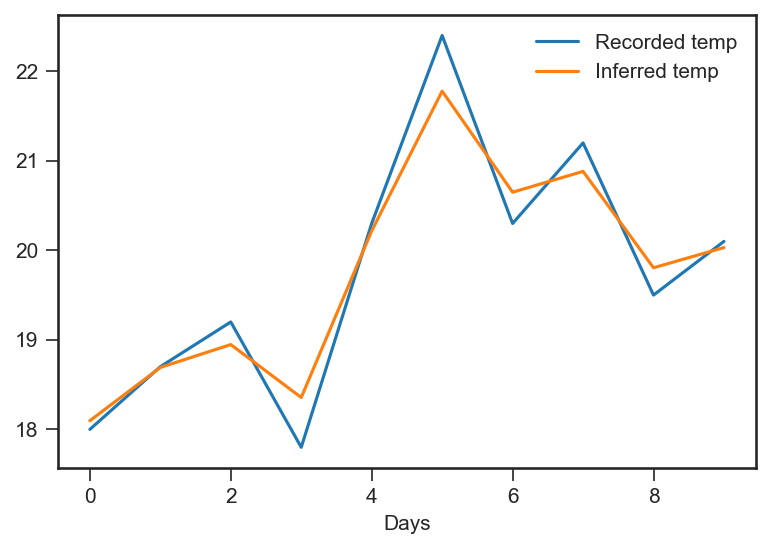

In [130]:
plt.figure(dpi=150)
plt.plot([obs['sensor'][i] for i in range(obs['sensor'].shape[0])], label="Recorded temp")
plt.plot([smoothed_temp['sensor'][i] for i in range(smoothed_temp['sensor'].shape[0])], label="Inferred temp")
plt.xlabel('Days')
plt.legend();

### Extended temporal model with Humidity

Our goal in this section is to implement the following graphical representation:

<img src="https://github.com/erikaja/probabilisticAI_tutorials/raw/40b644dccee2d26e469bb5fd32ae01e430e66200/Day1/slides/Figures/icecream-model-temporal.png" style="width: 80%">

Here,
<ul style="list-style: none; margin: 0 auto;">
    <li>$\mu_t$ is the mean of the temperature</li>
    <li>$\mu_h$ is the mean of the humidity</li>
    <li>$t_i$ is the true temperature at day $i$</li>
    <li>$h_i$ is the true humidity at day $i$</li>
    <li>$s_{t, i}$ is the recorded temperature at day $i$</li>
    <li>$s_{h, i}$ is the recorded humidity at day $i$</li>
    <li>$s_i$ are the ice cream sales at day $i$</li>
    <li>$\theta$ are the parameters of the linear dependence between temperature, humidity and ice cream sales</li>
</ul>

In [170]:
# The observations
# obs = {'sensor': torch.tensor([18., 18.7, 19.2, 17.8, 20.3, 22.4, 20.3, 21.2, 19.5, 20.1]),
# 'sales': torch.tensor([46., 47., 49., 44., 50., 54., 51., 52., 49., 53.]),
#       'sensor_humidity': torch.tensor([82.8, 87.6, 69.1, 74.2, 80.3, 94.2, 91.2, 92.2, 99.1, 93.2])/10.}

obs = {'sensor': torch.tensor([18., 18.7, 19.2, 17.8, 20.3, 22.4, 20.3, 21.2]),
    'sales': torch.tensor([46., 47., 49., 44., 50., 54., 51., 52.,]),
    'sensor_humidity': torch.tensor([82.8, 87.6, 69.1, 74.2, 80.3, 94.2, 91.2, 92.2,])/10.}

In [171]:
def model(obs):
    mean_temp = pyro.sample('mean_temp', dist.Normal(15.0, 2.0))
    mean_humidity = pyro.sample('mean_humidity', dist.Normal(8.0, 2.0))

    alpha = pyro.sample('alpha', dist.Normal(0.0, 100.0))
    beta = pyro.sample('beta', dist.Normal(0.0, 100.0))
    gamma = pyro.sample('gamma', dist.Normal(0.0, 100.0))

    for i in range(obs['sensor'].shape[0]):
        if i == 0:
            temp = pyro.sample(
                f"temp_{i}", dist.Normal(mean_temp, 2.0))
            humidity = pyro.sample(
                f"humidity_{i}", dist.Normal(mean_humidity, 2.0))
        else:
            temp = pyro.sample(f"temp_{i}", dist.Normal(prev_temp, 2.0))
            humidity = pyro.sample(
                f"humidity_{i}", dist.Normal(prev_humidity, 2.0))

        sensor = pyro.sample(f'sensor_{i}', dist.Normal(
            temp, 1.0), obs=obs['sensor'][i])
        sensor_humidity = pyro.sample(f'sensor_humidity_{i}', dist.Normal(
            humidity, 1.0), obs=obs['sensor_humidity'][i])
        rate = torch.max(torch.tensor(0.001), alpha + beta*temp + gamma*humidity)
        sales = pyro.sample(f'sales{i}', dist.Poisson(rate), obs=obs['sales'][i])

        prev_temp = temp
        prev_humidity = humidity

In [172]:
#Define the guide
def guide(obs):
    mean = pyro.param("mean", torch.mean(obs['sensor']))
    scale = pyro.param("scale", torch.tensor(
        1.), constraint=constraints.positive)
    mean_temp = pyro.sample('mean_temp', dist.Normal(mean, scale))

    meanH = pyro.param("meanH", torch.mean(
        obs['sensor_humidity']), constraint=constraints.positive)
    scaleH = pyro.param("scaleH", torch.tensor(
        1.), constraint=constraints.greater_than(0.01))
    humidity_mean = pyro.sample('mean_humidity', dist.Normal(meanH, scaleH))

    alpha_mean = pyro.param("alpha_mean", torch.mean(obs['sensor']))
    alpha_scale = pyro.param("alpha_scale", torch.tensor(
        1.), constraint=constraints.positive)
    alpha = pyro.sample('alpha', dist.Normal(alpha_mean, alpha_scale))

    beta_mean = pyro.param("beta_mean", torch.tensor(0.0))
    beta_scale = pyro.param("beta_scale", torch.tensor(
        1.), constraint=constraints.positive)
    beta = pyro.sample('beta', dist.Normal(beta_mean, beta_scale))

    gamma_mean = pyro.param("gamma_mean", torch.tensor(0.0))
    gamma_scale = pyro.param("gamma_scale", torch.tensor(
        1.), constraint=constraints.positive)
    gamma = pyro.sample('gamma', dist.Normal(gamma_mean, gamma_scale))

    for i in range(obs['sensor'].shape[0]):
        mean_i = pyro.param(f'mean_{i}', obs['sensor'][i])
        scale_i = pyro.param(f'scale_{i}', torch.tensor(
            1.), constraint=constraints.positive)
        temp = pyro.sample(f'temp_{i}', dist.Normal(mean_i, scale_i))
        meanH_i = pyro.param(f'meanH_{i}', obs['sensor_humidity'][i])
        scaleH_i = pyro.param(f'scaleH_{i}', torch.tensor(
            1.), constraint=constraints.positive)
        humidity_i = pyro.sample(
            f'humidity_{i}', dist.Normal(meanH_i, scaleH_i))

In [173]:
import time

start = time.time()
#Run inference
svi(model, guide, obs, num_steps=2000)


smooth_temp=[]
smooth_humidity=[]

for i in range(obs['sensor'].shape[0]):
    smooth_temp.append(pyro.param(f'mean_{i}').item())
    smooth_humidity.append(pyro.param(f'meanH_{i}').item())

end = time.time()
print(f'Finished in {round(end-start, 2)} s')

Finished in 62.83 s


In [174]:
def pred_sales(alpha, beta, gamma, temp, humidity):
    # alpha, beta, gamma: Scalars, coefficients of linear model
    # temp, humidity: numpy arrays, recorded values
    return alpha + beta * temp + gamma * humidity

In [175]:
alpha = pyro.param("alpha_mean").item()
beta = pyro.param("beta_mean").item()
gamma = pyro.param("gamma_mean").item()
temp_array = np.array([18., 18.7, 19.2, 17.8, 20.3, 22.4, 20.3, 21.2, 19.5, 20.1])
humidity_array = np.array([82.8, 87.6, 69.1, 74.2, 80.3, 94.2, 91.2, 92.2, 99.1, 93.2]) / 10
prediction = pred_sales(alpha, beta, gamma, temp_array, humidity_array)
prediction

array([48.36742739, 49.5668938 , 49.19936138, 47.6211443 , 51.28841912,
       54.85890285, 51.89697705, 53.15042211, 51.27349616, 51.7425026 ])

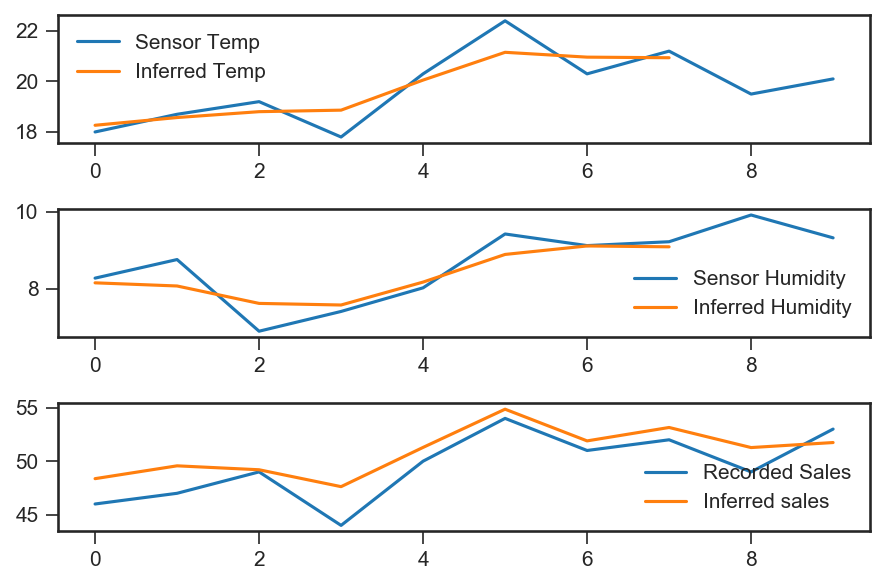

In [176]:
fig, axes = plt.subplots(3, 1, dpi=150)
axes[0].plot([18., 18.7, 19.2, 17.8, 20.3, 22.4, 20.3, 21.2, 19.5, 20.1], label='Sensor Temp')
axes[0].plot(smooth_temp, label='Inferred Temp')
axes[0].legend()
humidity = torch.tensor([82.8, 87.6, 69.1, 74.2, 80.3, 94.2, 91.2, 92.2, 99.1, 93.2])/10.
axes[1].plot(humidity.detach().numpy(), label='Sensor Humidity')
axes[1].plot(smooth_humidity, label='Inferred Humidity')
axes[1].legend()
axes[2].plot([46., 47., 49., 44., 50., 54., 51., 52., 49., 53.], label="Recorded Sales")
axes[2].plot(prediction, label="Inferred sales")
axes[2].legend()
plt.tight_layout();